In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

try:
    my_font = fm.FontProperties(fname='/content/drive/MyDrive/SourceHanSansSC-Regular.otf', size=11) #调整字体和字号
except:
    my_font = None

fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False

print("实际字体名:", my_font.get_name())  # 检查

实际字体名: Source Han Sans SC


Saving pca.xlsx to pca.xlsx
n_std = 2.447746830680816


<ipython-input-3-dec26a93964b>:37: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


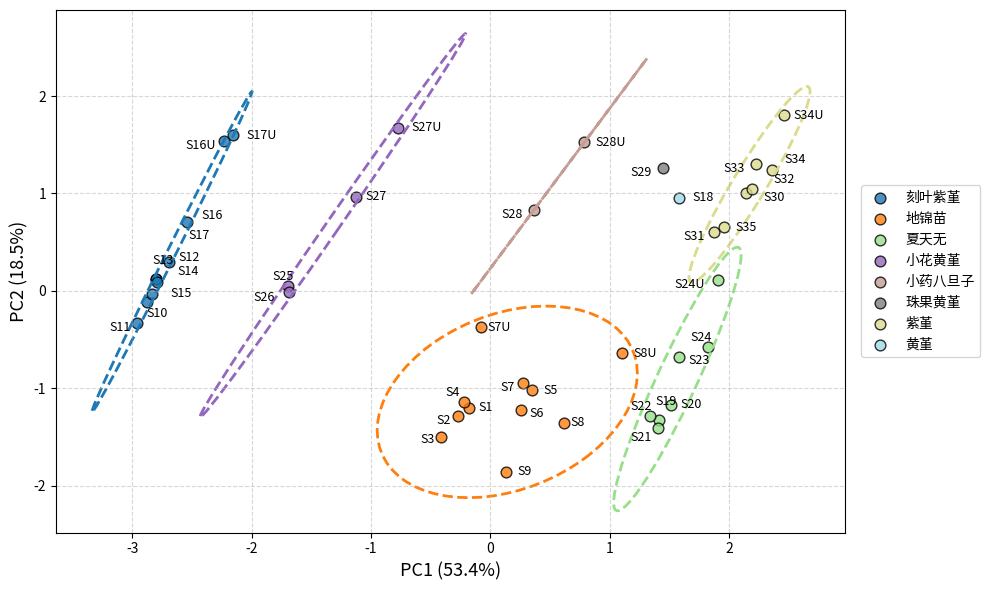

R²X (前2主成分累计解释率): 0.7197，百分比: 71.97%
Q² (7折交叉验证，前2主成分): 0.6860


In [3]:
from google.colab import files
uploaded = files.upload()  #PCA分析：将xlsx文件命名为pca.xlsx再上传

!pip install openpyxl
!pip install adjustText

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.model_selection import KFold
from adjustText import adjust_text
from scipy.stats import chi2

df = pd.read_excel('pca.xlsx')
sample_names = df.iloc[:, 0].astype(str)
groups = df.iloc[:, 1].astype(str)
X = df.iloc[:, 2:].values

# UV标准化（均值中心化+方差标准化，可以根据需求调整）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

conf_level = 0.95    # 置信度，默认95%
n_std = np.sqrt(chi2.ppf(conf_level, df=2))
print('n_std =', n_std)

def confidence_ellipse(x, y, ax, n_std=1.645, **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      fill=False,
                      **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(np.mean(x), np.mean(y))
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

plt.figure(figsize=(10, 6)) #设置画布大小
ax = plt.gca()
unique_groups = np.unique(groups)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_groups)))

texts = []
#设置样品名的偏移距离
x_range = X_pca[:, 0].max() - X_pca[:, 0].min()
offset_min = x_range * 0.008  # 最小偏移（约0.8%）
offset_max = x_range * 0.020  # 最大偏移（约2%）

for i, group in enumerate(unique_groups):
    idx = groups == group
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], label=group, color=colors[i], s=60, edgecolors='k', alpha=0.8)
    confidence_ellipse(X_pca[idx, 0], X_pca[idx, 1], ax, n_std=n_std, edgecolor=colors[i], linestyle='--', linewidth=2)
    for x, y, name in zip(X_pca[idx, 0], X_pca[idx, 1], sample_names[idx]):
        direction = np.random.choice([-1, 1])
        offset = direction * np.random.uniform(offset_min, offset_max)
        ha = 'right' if direction == -1 else 'left'
        txt = ax.text(x + offset, y, str(name), fontsize=9, fontproperties=my_font, va='center', ha=ha)
        texts.append(txt)
adjust_text(
    texts,
    expand_text=(2, 2),
    expand_points=(2, 2),
    ax=ax
)

ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize=13)
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize=13)
ax.legend(
    title=None,
    fontsize=11,
    title_fontproperties=my_font,
    prop=my_font,
    loc='center left',             # 图例对齐到“中心左”
    bbox_to_anchor=(1.02, 0.5),    # x轴1.02表示图外右侧，y轴0.5表示垂直中间
    borderaxespad=0.0,
    frameon=True
)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("pca_with_ellipse.svg", bbox_inches='tight')  # 输出格式，可选svg，pdf为矢量图，或者其他位图格式
plt.show()

# 输出R²X
R2X = explained_variance[:2].sum()
print(f"R²X (前2主成分累计解释率): {R2X:.4f}，百分比: {R2X*100:.2f}%")

# Q²计算 和simca的有差距，偏大
def pca_q2(X, n_comp=2, n_splits=7):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    SS_err = 0
    SS_tot = 0
    for train_idx, test_idx in kf.split(X):
        X_train = X[train_idx]
        X_test = X[test_idx]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        pca = PCA(n_components=n_comp)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        X_test_recon = pca.inverse_transform(X_test_pca)
        SS_err += np.sum((X_test_scaled - X_test_recon) ** 2)
        SS_tot += np.sum((X_test_scaled) ** 2)
    Q2 = 1 - SS_err / SS_tot
    return Q2

Q2 = pca_q2(X, n_comp=2, n_splits=7)
print(f"Q² (7折交叉验证，前2主成分): {Q2:.4f}")


Saving opls-da.xlsx to opls-da.xlsx


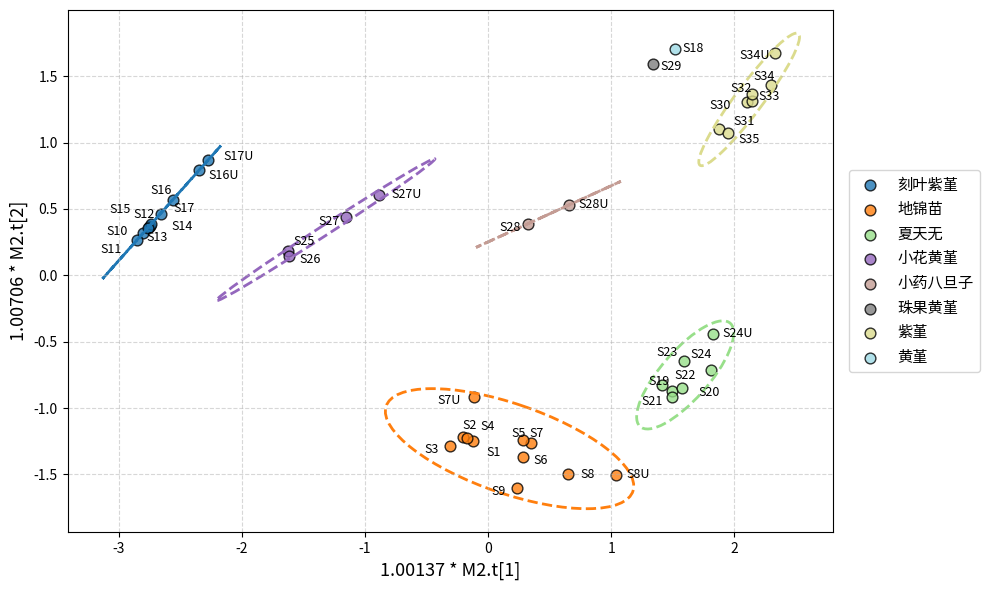

In [5]:
from google.colab import files
uploaded = files.upload()  #OPLS-DA绘图：将xlsx文件命名为opls-da.xlsx再上传
!pip install openpyxl
!pip install adjustText
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
from scipy.stats import chi2
import matplotlib.font_manager as fm
import random
from adjustText import adjust_text

df = pd.read_excel('opls-da.xlsx')

#列名设置
xcol = '1.00137 * M2.t[1]'
ycol = '1.00706 * M2.t[2]'
group_col = 'Obs ID ($ClassID)'
name_col = 'Obs ID (Primary)'

X_plot = df[[xcol, ycol]].values
groups = df[group_col].values
sample_names = df[name_col].values

try:
    my_font = fm.FontProperties(fname='/content/drive/MyDrive/SourceHanSansSC-Regular.otf', size=11) #调整字体和字号
except:
    my_font = None

conf_level = 0.95 #置信度，默认为95%
n_std = np.sqrt(chi2.ppf(conf_level, df=2))

def confidence_ellipse(x, y, ax, n_std=1.645, **kwargs):
    if x.size != y.size or x.size < 2:
        return
    cov = np.cov(x, y)
    if np.any(np.isnan(cov)):
        return
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * n_std * np.sqrt(vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    ellipse = Ellipse((mean_x, mean_y), width=width, height=height,
                      angle=angle, fill=False, **kwargs)
    return ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(10, 6)) #画布大小
unique_groups = np.unique(groups)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_groups)))
conf_level = 0.95
n_std = np.sqrt(chi2.ppf(conf_level, df=2))

texts = []
#样品名偏移
x_range = X_plot[:, 0].max() - X_plot[:, 0].min()
offset_min = x_range * 0.008  # 最小偏移
offset_max = x_range * 0.020  # 最大偏移

for i, group in enumerate(unique_groups):
    idx = groups == group
    ax.scatter(X_plot[idx, 0], X_plot[idx, 1], label=group, color=colors[i], s=60, edgecolors='k', alpha=0.8)
    confidence_ellipse(X_plot[idx, 0], X_plot[idx, 1], ax, n_std=n_std, edgecolor=colors[i], linestyle='--', linewidth=2)
    for x, y, name in zip(X_plot[idx, 0], X_plot[idx, 1], sample_names[idx]):
        direction = np.random.choice([-1, 1])
        offset = direction * np.random.uniform(offset_min, offset_max)
        ha = 'right' if direction == -1 else 'left'
        txt = ax.text(x + offset, y, str(name), fontsize=9, fontproperties=my_font, va='center', ha=ha)
        texts.append(txt)
adjust_text(
    texts,
    expand_text=(2, 2),
    expand_points=(2, 2),
    ax=ax
)

ax.set_xlabel(xcol, fontsize=13, fontproperties=my_font)
ax.set_ylabel(ycol, fontsize=13, fontproperties=my_font)
ax.legend(
    title=None,
    fontsize=11,
    title_fontproperties=my_font,
    prop=my_font,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
    frameon=True
)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("oplsda_with_ellipse.svg", bbox_inches='tight') # 输出格式，可选svg，pdf为矢量图，或者其他位图格式
plt.show()
